In [3]:
import os
import pandas as pd
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

Logistic Regression (LR)

Linear Discriminant Analysis (LDA)

K-Nearest Neighbor (KNN)

Decision Tree (CART)

Naïve Bayes (NB)

Support Vector Machine (SVM)

AdaBoost (AB)

Gradient Boosting Machine (GBM)

Random Forest (RF)

Extra Trees (ET)

Multi-Layer Perceptron (MLP)

In [4]:
inner_dir = "./AIDS/"
edge_list = pd.read_csv(os.path.join(inner_dir, 'AIDS_A.txt'), header=None)
edge_labels = pd.read_csv(os.path.join(inner_dir, 'AIDS_edge_labels.txt'), header=None)
node_attributes = pd.read_csv(os.path.join(inner_dir, 'AIDS_node_attributes.txt'), header=None)
node_labels = pd.read_csv(os.path.join(inner_dir, 'AIDS_node_labels.txt'), header=None)
graph_indicator = pd.read_csv(os.path.join(inner_dir, 'AIDS_graph_indicator.txt'), header=None)
graph_labels = pd.read_csv(os.path.join(inner_dir, 'AIDS_graph_labels.txt'), header=None)

# Set column names
edge_list.columns = ['source', 'target']
edge_labels.columns = ['bond_type']
node_labels.columns = ['atom_type']
graph_indicator.columns = ['graph_id']
graph_labels.columns = ['graph_label']

preserve both node attributes (chem, charge, x, y) and bond types (valence).

In [5]:
graph_id_to_nodes = graph_indicator.reset_index().groupby('graph_id')['index'].apply(list).to_dict()

graphs = {}
for graph_id, nodes in graph_id_to_nodes.items():
    node_set = set(nodes)
    
    # Filter edges for this graph
    graph_edges = edge_list[edge_list['source'].isin(node_set) & edge_list['target'].isin(node_set)].copy()
    graph_edges['bond_type'] = edge_labels.loc[graph_edges.index, 'bond_type']
    
    G = nx.Graph()
    
    # Add nodes with atom label and optional attributes
    for node in nodes:
        atom_type = node_labels.iloc[node, 0]
        attr_row = node_attributes.iloc[node].tolist()
        G.add_node(node, atom_label=atom_type, features=attr_row)
    
    # Add edges with bond type
    for idx, row in graph_edges.iterrows():
        G.add_edge(int(row['source']), int(row['target']), bond_type=int(row['bond_type']))
    
    graphs[graph_id] = G

## Feature Engineering 

In [6]:
# Map integer node labels back to atomic numbers
# You need this map because AIDS uses a symbol-to-integer encoding
symbol_to_atomic_number = {
    'C': 6, 'O': 8, 'N': 7, 'Cl': 17, 'F': 9, 'S': 16, 'Se': 34, 'P': 15, 'Na': 11,
    'I': 53, 'Co': 27, 'Br': 35, 'Li': 3, 'Si': 14, 'Mg': 12, 'Cu': 29, 'As': 33,
    'B': 5, 'Pt': 78, 'Ru': 44, 'K': 19, 'Pd': 46, 'Au': 79, 'Te': 52, 'W': 74,
    'Rh': 45, 'Zn': 30, 'Bi': 83, 'Pb': 82, 'Ge': 32, 'Sb': 51, 'Sn': 50,
    'Ga': 31, 'Hg': 80, 'Ho': 67, 'Tl': 81, 'Ni': 28, 'Tb': 65
}

# Inverse map of integer node labels (0–37) to symbols
int_to_symbol = {
    0: 'C', 1: 'O', 2: 'N', 3: 'Cl', 4: 'F', 5: 'S', 6: 'Se', 7: 'P', 8: 'Na', 9: 'I',
    10: 'Co', 11: 'Br', 12: 'Li', 13: 'Si', 14: 'Mg', 15: 'Cu', 16: 'As', 17: 'B',
    18: 'Pt', 19: 'Ru', 20: 'K', 21: 'Pd', 22: 'Au', 23: 'Te', 24: 'W', 25: 'Rh',
    26: 'Zn', 27: 'Bi', 28: 'Pb', 29: 'Ge', 30: 'Sb', 31: 'Sn', 32: 'Ga', 33: 'Hg',
    34: 'Ho', 35: 'Tl', 36: 'Ni', 37: 'Tb'
}

# Edge label (0, 1, 2) to bond type
edge_label_to_bondtype = {
    0: Chem.rdchem.BondType.SINGLE,
    1: Chem.rdchem.BondType.DOUBLE,
    2: Chem.rdchem.BondType.TRIPLE
}

# Updated helper
def graph_to_molecule(G):
    mol = Chem.RWMol()
    idx_map = {}  # Mapping from graph node id to mol atom id

    for node, data in G.nodes(data=True):
        label_idx = int(data['atom_label'])
        symbol = int_to_symbol[label_idx]
        atomic_number = symbol_to_atomic_number[symbol]
        atom = Chem.Atom(atomic_number)
        atom_idx = mol.AddAtom(atom)
        idx_map[node] = atom_idx

    for u, v, attr in G.edges(data=True):
        bond_type = edge_label_to_bondtype.get(attr.get('bond_type', 0), Chem.rdchem.BondType.SINGLE)
        try:
            mol.AddBond(idx_map[u], idx_map[v], bond_type)
        except:
            continue  # skip invalid bonds

    return mol.GetMol()

In [7]:
from rdkit import Chem

# Extended valence map for more elements seen in AIDS
max_valence = {
    1: 1,   # H
    5: 4,  # B
    6: 4,   # C
    7: 3,   # N
    8: 2,   # O
    9: 1,   # F
    15: 5,  # P
    16: 6,  # S (we allow extended valence here)
    17: 1,  # Cl
    35: 1,  # Br
    53: 1,  # I
    11: 1,  # Na
    12: 2,  # Mg
    13: 3,  # Al/Si
    14: 4,
    27: 3,  # Co
    30: 2,  # Zn
    33: 5,  # As
    34: 2,  # Se
    44: 6,  # Ru
    45: 3,  # Rh
    46: 4,  # Pd
    78: 4,  # Pt
    79: 3,  # Au
    80: 2,  # Hg
}

def fix_valence(mol):
    rw_mol = Chem.RWMol(mol)
    rw_mol.UpdatePropertyCache(strict=False)  # <- fixes the pre-condition violation
    
    for atom in rw_mol.GetAtoms():
        atomic_num = atom.GetAtomicNum()
        allowed = max_valence.get(atomic_num)
        if allowed is None:
            continue  # Unknown atom, skip

        actual = atom.GetExplicitValence()
        if actual <= allowed:
            continue  # All good

        # Remove weakest bonds first (e.g. single bonds to hydrogen)
        bonds_to_remove = []
        for bond in atom.GetBonds():
            neighbor = bond.GetOtherAtom(atom)
            bond_order = bond.GetBondTypeAsDouble()
            is_H = neighbor.GetAtomicNum() == 1
            bonds_to_remove.append((
                bond_order,
                is_H,
                bond.GetIdx(),
                atom.GetIdx(),
                neighbor.GetIdx()
            ))
        
        bonds_to_remove.sort()  # weakest, H-first

        for _, _, _, idx1, idx2 in bonds_to_remove:
            rw_mol.RemoveBond(idx1, idx2)
            rw_mol.UpdatePropertyCache(strict=False)
            new_valence = rw_mol.GetAtomWithIdx(idx1).GetExplicitValence()
            if new_valence <= allowed:
                break

    return rw_mol.GetMol()

In [8]:
fingerprints = {}
broken_molecules = []

for graph_id, G in tqdm(graphs.items()):
    mol = graph_to_molecule(G)
    try:
        mol = fix_valence(mol)
        Chem.SanitizeMol(mol)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        fingerprints[graph_id] = fp
    except Exception as e:
        # Try again with partial sanitization
        try:
            mol = fix_valence(mol)
            Chem.SanitizeMol(mol, sanitizeOps=Chem.SANITIZE_ALL ^ Chem.SANITIZE_PROPERTIES)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
            fingerprints[graph_id] = fp
            print(f"Graph {graph_id} succeeded with partial sanitization")
        except Exception as e2:
            print(f"Graph {graph_id} failed even with partial sanitization: {e2}")
            broken_molecules.append(graph_id)

  0%|          | 0/2000 [00:00<?, ?it/s][16:33:44] DEPRECATION WARNING: please use MorganGenerator
[16:33:44] DEPRECATION WARNING: please use MorganGenerator
[16:33:44] DEPRECATION WARNING: please use MorganGenerator
[16:33:44] DEPRECATION WARNING: please use MorganGenerator
[16:33:44] DEPRECATION WARNING: please use MorganGenerator
[16:33:44] DEPRECATION WARNING: please use MorganGenerator
[16:33:44] DEPRECATION WARNING: please use MorganGenerator
[16:33:44] DEPRECATION WARNING: please use MorganGenerator
[16:33:44] DEPRECATION WARNING: please use MorganGenerator
[16:33:44] DEPRECATION WARNING: please use MorganGenerator
[16:33:44] DEPRECATION WARNING: please use MorganGenerator
[16:33:44] DEPRECATION WARNING: please use MorganGenerator
[16:33:44] DEPRECATION WARNING: please use MorganGenerator
[16:33:44] DEPRECATION WARNING: please use MorganGenerator
[16:33:44] DEPRECATION WARNING: please use MorganGenerator
[16:33:44] DEPRECATION WARNING: please use MorganGenerator
[16:33:44] DEPRE

Graph 1485 succeeded with partial sanitization


In [9]:
print(f"Graphs total: {len(graphs)}")
print(f"Fingerprints successfully generated: {len(fingerprints)}")
print(f"Graphs that failed: {len(broken_molecules)}")

Graphs total: 2000
Fingerprints successfully generated: 2000
Graphs that failed: 0


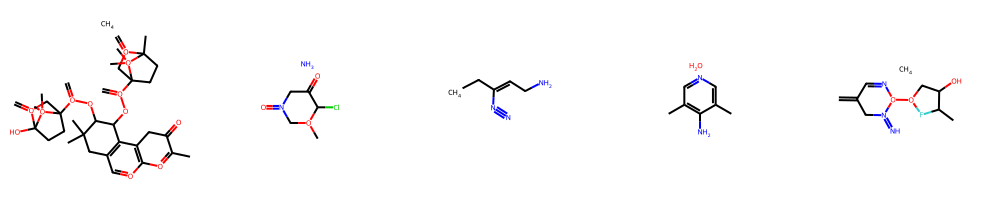

In [10]:
from IPython.display import display
from rdkit.Chem import Draw

# Pick 5 graphs, each graph individually represents a single molecule 
mols = [graph_to_molecule(G) for G in list(graphs.values())[:5]]

# Draw them
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))

# Show image
display(img)

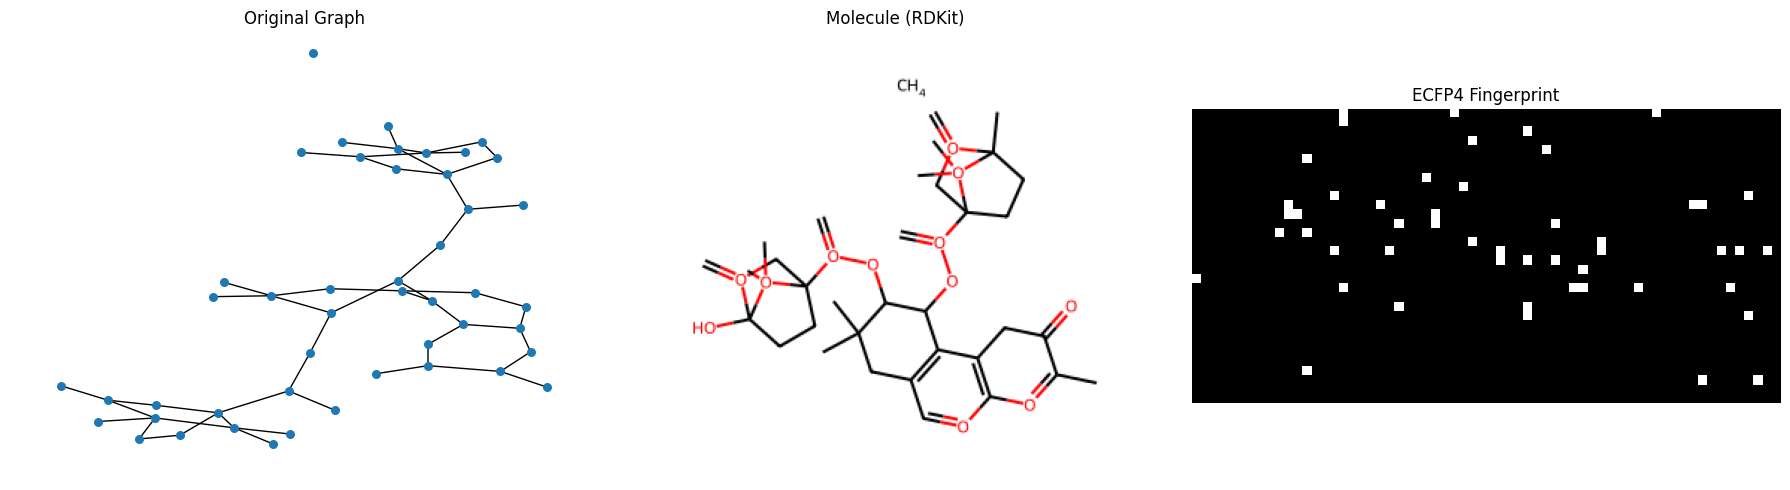

In [11]:
# Select the first graph
graph_id = list(graphs.keys())[0]
G = graphs[graph_id]
fp = fingerprints[graph_id]

# Create molecule from graph
mol = graph_to_molecule(G)

# Prepare fingerprint image
fp_array = np.array(fp)
if fp_array.shape[0] == 2048:
    fp_image = fp_array.reshape(32, 64)
else:
    side = int(np.ceil(np.sqrt(len(fp_array))))
    padded_fp = np.zeros(side * side)
    padded_fp[:len(fp_array)] = fp_array
    fp_image = padded_fp.reshape((side, side))

# Generate the molecule drawing
mol_img = Draw.MolToImage(mol, size=(300, 300))

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. Plot the original graph
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=False, node_size=30, ax=axs[0])
axs[0].set_title('Original Graph')
axs[0].axis('off')

# 2. Show molecule image
axs[1].imshow(mol_img)
axs[1].axis('off')
axs[1].set_title('Molecule (RDKit)')

# 3. Show fingerprint image
axs[2].imshow(fp_image, cmap='gray')
axs[2].axis('off')
axs[2].set_title('ECFP4 Fingerprint')

plt.tight_layout()
plt.show()

In [12]:
# ========== Save Fingerprints ==========
fp_array = np.array([list(fp.ToBitString()) for fp in fingerprints.values()], dtype=int)
print(fp_array.shape) 

(2000, 2048)


In [13]:
# ========== Compute Graph Theoretical Features ==========
def compute_graph_features(G):
    features = {}

    # Basic metrics
    features['num_nodes'] = G.number_of_nodes()
    features['num_edges'] = G.number_of_edges()

    # Density
    features['density'] = nx.density(G)

    # Degree stats
    degrees = [deg for node, deg in G.degree()]
    features['degree_mean'] = np.mean(degrees)
    features['degree_std'] = np.std(degrees)
    features['degree_max'] = np.max(degrees)
    features['degree_min'] = np.min(degrees)

    # Clustering coefficient
    features['avg_clustering'] = nx.average_clustering(G)

    # Shortest-path metrics
    if nx.is_connected(G):
        features['diameter'] = nx.diameter(G)
        features['radius'] = nx.radius(G)
        features['avg_shortest_path'] = nx.average_shortest_path_length(G)
    else:
        # Use the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(largest_cc)
        features['diameter'] = nx.diameter(G_sub)
        features['radius'] = nx.radius(G_sub)
        features['avg_shortest_path'] = nx.average_shortest_path_length(G_sub)

    # SPID (Shortest Path Induced Diameter)
    sp_lengths = dict(nx.all_pairs_shortest_path_length(G))
    max_spl = max(max(lengths.values()) for lengths in sp_lengths.values())
    features['spid'] = max_spl

    return features

In [14]:
# ========== Get Graph Theoretical Features ==========
#graphs = {graph_id: networkx.Graph}
graph_features_list = []

for graph_id, G in graphs.items():
    feats = compute_graph_features(G)
    feats['graph_id'] = graph_id
    graph_features_list.append(feats)

# Convert to DataFrame
graph_features_df = pd.DataFrame(graph_features_list)
graph_features_df.set_index('graph_id', inplace=True)

print(graph_features_df.head())

          num_nodes  num_edges   density  degree_mean  degree_std  degree_max  \
graph_id                                                                        
1                47         52  0.048104     2.212766    1.090309           4   
2                11         10  0.181818     1.818182    1.028519           3   
3                 9          7  0.194444     1.555556    0.831479           3   
4                10          9  0.200000     1.800000    0.979796           3   
5                16         16  0.133333     2.000000    0.935414           3   

          degree_min  avg_clustering  diameter  radius  avg_shortest_path  \
graph_id                                                                    
1                  0             0.0        13       7           6.345894   
2                  0             0.0         5       3           2.444444   
3                  0             0.0         5       3           2.571429   
4                  0             0.0         4 

# Status: 
We have a set of fingerprints (fp) — one fingerprint vector per graph
Input to ML classifier must be a matrix X 
Fingerprints are not a matrix yet -> need to convert them 
Fingerprints are bit vectors (long 0/1 arrays (e.g., 2048 bits for Morgan))
Fingerprint matrix: Rows = molecules/graphs || Columns = fingerprint bits


In [15]:
fingerprint_rows = []
graph_ids = []

for graph_id, fp in fingerprints.items():
    arr = np.array(fp)  # RDKit bitvector to numpy array
    fingerprint_rows.append(arr)
    graph_ids.append(graph_id)

X_fingerprint = np.stack(fingerprint_rows)

# Create DataFrame
X_fingerprint_df = pd.DataFrame(X_fingerprint, index=graph_ids)
X_fingerprint_df.index.name = 'graph_id'

print(X_fingerprint_df.shape)
print(X_fingerprint_df.head())

(2000, 2048)
          0     1     2     3     4     5     6     7     8     9     ...  \
graph_id                                                              ...   
1            0     0     0     0     0     0     0     0     0     0  ...   
2            0     1     0     0     0     0     0     0     0     0  ...   
3            0     0     0     0     0     0     0     0     0     0  ...   
4            0     0     0     0     0     0     0     0     0     0  ...   
5            0     1     0     0     0     0     0     0     0     0  ...   

          2038  2039  2040  2041  2042  2043  2044  2045  2046  2047  
graph_id                                                              
1            0     0     0     0     0     0     0     0     0     0  
2            0     0     0     0     0     0     0     0     0     0  
3            0     0     0     0     0     0     0     0     0     0  
4            0     0     0     0     0     0     0     0     0     0  
5            0     0 

In [16]:
density = X_fingerprint_df.values.sum() / X_fingerprint_df.size
print(f"Density: {density:.4f}")

Density: 0.0125


Very sparse X-matrix: 
Molecular fingerprints like ECFP4 (Morgan fingerprints) are designed to be sparse.
Many ML models work fine with sparse data
For DL often better to reduce dimension (e.g., PCA to 256 or 512)


In [17]:
X_fingerprint_df

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
graph_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
graph_labels.index = np.arange(1, len(graph_labels) + 1)
graph_labels.index.name = 'graph_id'

# Now you can access labels
y = graph_labels.loc[X_fingerprint_df.index]['graph_label'].values

print(X_fingerprint_df.shape)
print(y.shape)
print(np.unique(y))

(2000, 2048)
(2000,)
[0 1]


# Training ML Classifiers

In [19]:
# Import all classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')


In [20]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'Support Vector Machine': SVC(probability=True),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Multi-Layer Perceptron': MLPClassifier(max_iter=1000)
}

In [21]:
# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics
scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc'
}

In [22]:
def is_binary_features(X):
        """
        Check if all features in the dataset are binary (contain only 0s and 1s).
        """
        return ((X == 0) | (X == 1)).all().all()

In [23]:
def evaluate_models(X, y, models_to_run, cv_strategy, scoring_metrics):
    """
    Train and evaluate multiple classifiers with cross-validation.
    
    Args:
        X (pd.DataFrame): Feature matrix
        y (np.array): Labels
        models_to_run (dict): Dictionary of model_name: sklearn model object
        cv_strategy (sklearn CV object): Cross-validation strategy
        scoring_metrics (dict): Dictionary of scorers
        
    Returns:
        pd.DataFrame: Results with mean and std of scores
    """
    results = []

    for name, model in models_to_run.items():
        
        if not is_binary_features(X):
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', model)
            ])
        else:
            pipeline = Pipeline([
                ('classifier', model)
            ])

        scores = {}
        for score_name, score_func in scoring_metrics.items():
            cv_scores = cross_val_score(pipeline, X, y, scoring=score_func, cv=cv_strategy)
            scores[f'{score_name}_mean'] = cv_scores.mean()
            scores[f'{score_name}_std'] = cv_scores.std()
        
        scores['model'] = name
        results.append(scores)
    
    return pd.DataFrame(results)

In [24]:
X_graphmetrics_df = graph_features_df.copy()

X_graphmetrics_df.columns = [col.lower() for col in X_graphmetrics_df.columns]

print(X_graphmetrics_df.shape)
print(X_graphmetrics_df.head())

(2000, 12)
          num_nodes  num_edges   density  degree_mean  degree_std  degree_max  \
graph_id                                                                        
1                47         52  0.048104     2.212766    1.090309           4   
2                11         10  0.181818     1.818182    1.028519           3   
3                 9          7  0.194444     1.555556    0.831479           3   
4                10          9  0.200000     1.800000    0.979796           3   
5                16         16  0.133333     2.000000    0.935414           3   

          degree_min  avg_clustering  diameter  radius  avg_shortest_path  \
graph_id                                                                    
1                  0             0.0        13       7           6.345894   
2                  0             0.0         5       3           2.444444   
3                  0             0.0         5       3           2.571429   
4                  0             0.0

In [25]:
# Make sure columns are named
node_attributes.columns = ['chem', 'charge', 'x', 'y']
graph_indicator.columns = ['graph_id']

# Assign graph ID to each node
node_attributes['graph_id'] = graph_indicator['graph_id'].values
node_attributes['node_id'] = node_attributes.index

# Group by graph and aggregate node attributes
aggregated = node_attributes.groupby('graph_id').agg(
    chem_mean=('chem', 'mean'),
    chem_std=('chem', 'std'),
    charge_mean=('charge', 'mean'),
    charge_std=('charge', 'std'),
    x_mean=('x', 'mean'),
    x_std=('x', 'std'),
    y_mean=('y', 'mean'),
    y_std=('y', 'std'),
)

X_nodeattr_df = aggregated
X_nodeattr_df.index.name = 'graph_id'

In [26]:
# Join on graph_id index

X_combined_df = pd.concat([X_fingerprint_df, X_graphmetrics_df], axis=1)
X_combined_df.columns = X_combined_df.columns.astype(str)
print(X_combined_df.shape)
print(X_combined_df.head())

(2000, 2060)
          0  1  2  3  4  5  6  7  8  9  ...   density  degree_mean  \
graph_id                                ...                          
1         0  0  0  0  0  0  0  0  0  0  ...  0.048104     2.212766   
2         0  1  0  0  0  0  0  0  0  0  ...  0.181818     1.818182   
3         0  0  0  0  0  0  0  0  0  0  ...  0.194444     1.555556   
4         0  0  0  0  0  0  0  0  0  0  ...  0.200000     1.800000   
5         0  1  0  0  0  0  0  0  0  0  ...  0.133333     2.000000   

          degree_std  degree_max  degree_min  avg_clustering  diameter  \
graph_id                                                                 
1           1.090309           4           0             0.0        13   
2           1.028519           3           0             0.0         5   
3           0.831479           3           0             0.0         5   
4           0.979796           3           0             0.0         4   
5           0.935414           3           0        

In [27]:
models_lr = {'Logistic Regression': LogisticRegression(max_iter=1000)}

# Evaluate on fingerprints
results_fingerprint = evaluate_models(X_fingerprint_df, y, models_lr, cv, scoring)
# Evaluate on graph metrics
results_graph = evaluate_models(X_graphmetrics_df, y, models_lr, cv, scoring)
# Evaluate on combined features
results_combined = evaluate_models(X_combined_df, y, models_lr, cv, scoring)
# Evaluate on node attribute features alone
results_nodeattr = evaluate_models(X_nodeattr_df, y, models_lr, cv, scoring)

print("--- Fingerprints ---")
print(results_fingerprint)
print("\n--- Graph Metrics ---")
print(results_graph)
print("\n--- Combined ---")
print(results_combined)
print("\n--- Node Attributes ---")
print(results_nodeattr)

--- Fingerprints ---
   accuracy_mean  accuracy_std  roc_auc_mean  roc_auc_std                model
0          0.981      0.005612      0.992234     0.005264  Logistic Regression

--- Graph Metrics ---
   accuracy_mean  accuracy_std  roc_auc_mean  roc_auc_std                model
0         0.9955      0.002915      0.997332     0.003279  Logistic Regression

--- Combined ---
   accuracy_mean  accuracy_std  roc_auc_mean  roc_auc_std                model
0          0.973      0.006782      0.993422     0.003519  Logistic Regression

--- Node Attributes ---
   accuracy_mean  accuracy_std  roc_auc_mean  roc_auc_std                model
0          0.981      0.003391       0.99325     0.005173  Logistic Regression


In [28]:
X_combined_plus_nodeattr = pd.concat([X_combined_df, X_nodeattr_df], axis=1)
X_combined_plus_nodeattr.columns = X_combined_plus_nodeattr.columns.astype(str)

results_all = evaluate_models(X_combined_plus_nodeattr, y, models_lr, cv, scoring)
print("\n--- Combined + Node Attributes ---")
print(results_all)


--- Combined + Node Attributes ---
   accuracy_mean  accuracy_std  roc_auc_mean  roc_auc_std                model
0          0.975      0.006519      0.993055     0.003822  Logistic Regression


In [29]:
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier,
    RandomForestClassifier, ExtraTreesClassifier
)
from sklearn.neural_network import MLPClassifier

# Define classifiers
models = {
    "Logistic Regression (LR)": LogisticRegression(max_iter=1000),
    "Linear Discriminant Analysis (LDA)": LinearDiscriminantAnalysis(),
    "K-Nearest Neighbor (KNN)": KNeighborsClassifier(),
    "Decision Tree (CART)": DecisionTreeClassifier(),
    "Naïve Bayes (NB)": GaussianNB(),
    "Support Vector Machine (SVM)": SVC(probability=True),
    "AdaBoost (AB)": AdaBoostClassifier(),
    "Gradient Boosting (GBM)": GradientBoostingClassifier(),
    "Random Forest (RF)": RandomForestClassifier(),
    "Extra Trees (ET)": ExtraTreesClassifier(),
    "Multi-Layer Perceptron (MLP)": MLPClassifier(max_iter=1000)
}

# Add node attribute features and optional full combination
X_combined_plus_nodeattr_df = pd.concat([X_combined_df, X_nodeattr_df], axis=1)
X_combined_plus_nodeattr_df.columns = X_combined_plus_nodeattr_df.columns.astype(str)

# Define datasets
datasets = {
    "Fingerprints": X_fingerprint_df,
    "Graph Metrics": X_graphmetrics_df,
    "Node Attributes": X_nodeattr_df,
    "Combined": X_combined_df,
    "Combined + Node Attributes": X_combined_plus_nodeattr_df
}

# Evaluation settings
scoring = ['accuracy', 'roc_auc']
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Helper to check for binary-only features
def is_binary_features(df):
    return ((df == 0) | (df == 1)).all().all()

# Run evaluations
all_results = {}
for dataset_name, X_use in datasets.items():
    print(f"\n=== Running models on: {dataset_name} (shape: {X_use.shape}) ===")
    results = []

    for name, model in models.items():
        print(f"\nRunning: {name}")
        start_time = time.time()

        # Scale non-binary features
        if not is_binary_features(X_use):
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('clf', model)
            ])
        else:
            pipeline = Pipeline([
                ('clf', model)
            ])

        model_scores = {}
        for score_metric in scoring:
            cv_scores = cross_val_score(pipeline, X_use, y, scoring=score_metric, cv=cv)
            model_scores[f"{score_metric}_mean"] = cv_scores.mean()
            model_scores[f"{score_metric}_std"] = cv_scores.std()

        elapsed_time = time.time() - start_time

        print(f"Accuracy: {model_scores['accuracy_mean']:.4f} ± {model_scores['accuracy_std']:.4f}")
        print(f"ROC AUC: {model_scores['roc_auc_mean']:.4f} ± {model_scores['roc_auc_std']:.4f}")
        print(f"Training Time: {elapsed_time:.2f} seconds")

        results.append({
            'model': name,
            **model_scores,
            'time_sec': elapsed_time
        })

    # Save for analysis
    results_df = pd.DataFrame(results).sort_values('roc_auc_mean', ascending=False)
    all_results[dataset_name] = results_df


=== Running models on: Fingerprints (shape: (2000, 2048)) ===

Running: Logistic Regression (LR)
Accuracy: 0.9810 ± 0.0056
ROC AUC: 0.9922 ± 0.0053
Training Time: 0.67 seconds

Running: Linear Discriminant Analysis (LDA)


KeyboardInterrupt: 

=== Final Results ===
                                 model  accuracy_mean  accuracy_std  \
0             Logistic Regression (LR)       0.797621      0.032588   
10        Multi-Layer Perceptron (MLP)       0.796297      0.008762   
7              Gradient Boosting (GBM)       0.793682      0.038512   
8                   Random Forest (RF)       0.785744      0.040342   
5         Support Vector Machine (SVM)       0.788376      0.041160   
2             K-Nearest Neighbor (KNN)       0.780507      0.055670   
9                     Extra Trees (ET)       0.775157      0.047993   
6                        AdaBoost (AB)       0.777771      0.038559   
3                 Decision Tree (CART)       0.750061      0.050835   
1   Linear Discriminant Analysis (LDA)       0.709062      0.057017   
4                     Naïve Bayes (NB)       0.709010      0.038486   

    roc_auc_mean  roc_auc_std   time_sec  
0       0.875359     0.030003   0.840698  
10      0.865152     0.026959  12.689475  
7       0.863160     0.031335   8.300434  
8       0.861940     0.032218   1.500110  
5       0.859565     0.038361   7.157297  
2       0.850398     0.037423   0.186665  
9       0.848321     0.032992   1.677692  
6       0.841759     0.033705   3.054541  
3       0.752207     0.038868   0.443390  
1       0.735154     0.068318   1.729279  
4       0.696695     0.042112   0.212836

In [ ]:
all_results

{'Fingerprints':                                  model  accuracy_mean  accuracy_std  \
 5         Support Vector Machine (SVM)         0.9895      0.002915   
 0             Logistic Regression (LR)         0.9810      0.005612   
 8                   Random Forest (RF)         0.9455      0.007810   
 9                     Extra Trees (ET)         0.9505      0.004848   
 7              Gradient Boosting (GBM)         0.9640      0.004062   
 6                        AdaBoost (AB)         0.9625      0.009083   
 10        Multi-Layer Perceptron (MLP)         0.9290      0.009301   
 3                 Decision Tree (CART)         0.9160      0.009566   
 2             K-Nearest Neighbor (KNN)         0.8520      0.006205   
 1   Linear Discriminant Analysis (LDA)         0.7695      0.031992   
 4                     Naïve Bayes (NB)         0.5455      0.031796   
 
     roc_auc_mean  roc_auc_std   time_sec  
 5       0.992852     0.005332  22.231395  
 0       0.992234     0.005264

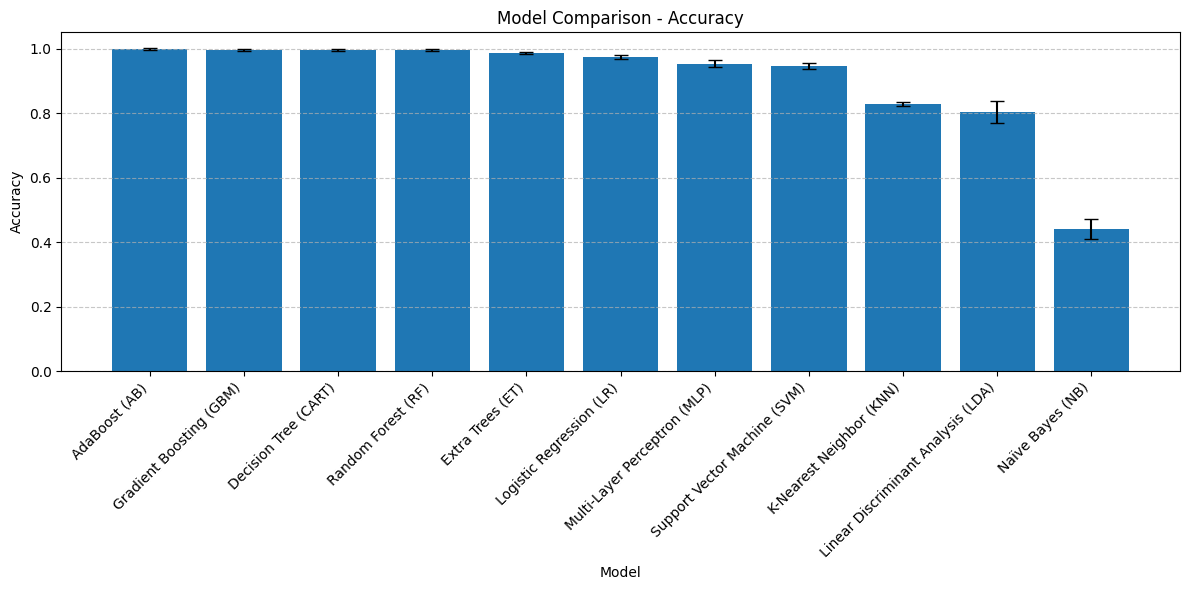

In [ ]:
# Sort by accuracy for better readability
results_df_sorted = results_df.sort_values('accuracy_mean', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(results_df_sorted['model'], results_df_sorted['accuracy_mean'], yerr=results_df_sorted['accuracy_std'], capsize=5)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Model Comparison - Accuracy')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [30]:


all_results = {
    'Fingerprints': pd.DataFrame({
        'model': [
            "Support Vector Machine (SVM)", "Logistic Regression (LR)", "Random Forest (RF)",
            "Extra Trees (ET)", "Gradient Boosting (GBM)", "AdaBoost (AB)",
            "Multi-Layer Perceptron (MLP)", "Decision Tree (CART)", "K-Nearest Neighbor (KNN)",
            "Linear Discriminant Analysis (LDA)", "Naïve Bayes (NB)"
        ],
        'accuracy_mean': [0.9895, 0.9810, 0.9455, 0.9505, 0.9640, 0.9625, 0.9290, 0.9160, 0.8520, 0.7695, 0.5455],
        'accuracy_std': [0.002915, 0.005612, 0.007810, 0.004848, 0.004062, 0.009083, 0.009301, 0.009566, 0.006205, 0.031992, 0.031796],
        'roc_auc_mean': [0.992852, 0.992234, 0.991391, 0.991125, 0.988793, 0.985797, 0.915516, 0.847500, 0.774484, 0.746352, 0.677996],
        'roc_auc_std': [0.005332, 0.005264, 0.005181, 0.005686, 0.003396, 0.005170, 0.016036, 0.010486, 0.023895, 0.027390, 0.019314],
        'time_sec': [22.231395, 0.748207, 2.985753, 3.857837, 25.849846, 8.219920, 11.987639, 1.342430, 0.424829, 14.780873, 0.359798]
    }),

    'Graph Metrics': pd.DataFrame({
        'model': [
            "Gradient Boosting (GBM)", "Multi-Layer Perceptron (MLP)", "Extra Trees (ET)", "Logistic Regression (LR)",
            "Support Vector Machine (SVM)", "AdaBoost (AB)", "Linear Discriminant Analysis (LDA)", "Decision Tree (CART)",
            "Random Forest (RF)", "Naïve Bayes (NB)", "K-Nearest Neighbor (KNN)"
        ],
        'accuracy_mean': [0.9985, 0.9965, 0.9970, 0.9955, 0.9970, 0.9985, 0.9820, 0.9985, 0.9975, 0.9960, 0.9955],
        'accuracy_std': [0.002000, 0.002550, 0.002915, 0.002915, 0.002915, 0.002000, 0.003674, 0.002000, 0.003162, 0.003391, 0.003317],
        'roc_auc_mean': [0.998238, 0.997605, 0.997383, 0.997332, 0.997129, 0.997023, 0.996242, 0.996238, 0.996125, 0.992629, 0.989937],
        'roc_auc_std': [0.002376, 0.003078, 0.003189, 0.003279, 0.003658, 0.003994, 0.003659, 0.005016, 0.005132, 0.009047, 0.008485],
        'time_sec': [1.128859, 1.513030, 0.545681, 0.032968, 0.200712, 0.508601, 0.030142, 0.031005, 0.701405, 0.023761, 0.069686]
    }),

    'Node Attributes': pd.DataFrame({
        'model': [
            "Extra Trees (ET)", "AdaBoost (AB)", "Logistic Regression (LR)", "Gradient Boosting (GBM)",
            "Support Vector Machine (SVM)", "Random Forest (RF)", "Linear Discriminant Analysis (LDA)",
            "Multi-Layer Perceptron (MLP)", "K-Nearest Neighbor (KNN)", "Decision Tree (CART)", "Naïve Bayes (NB)"
        ],
        'accuracy_mean': [0.9860, 0.9790, 0.9810, 0.9810, 0.9835, 0.9845, 0.9280, 0.9865, 0.9780, 0.9765, 0.9270],
        'accuracy_std': [0.002000, 0.005148, 0.003391, 0.004062, 0.004899, 0.003674, 0.004301, 0.001225, 0.008276, 0.009301, 0.011979],
        'roc_auc_mean': [0.993832, 0.993563, 0.993250, 0.993086, 0.992555, 0.991648, 0.990883, 0.990223, 0.985008, 0.964687, 0.935297],
        'roc_auc_std': [0.007435, 0.005158, 0.005173, 0.006145, 0.005075, 0.006527, 0.006408, 0.009036, 0.005743, 0.018398, 0.025720],
        'time_sec': [0.690019, 0.633232, 0.033333, 2.013454, 0.408006, 1.189349, 0.026436, 5.277284, 0.070836, 0.061298, 0.023433]
    }),

    'Combined': pd.DataFrame({
        'model': [
            "AdaBoost (AB)", "Random Forest (RF)", "Gradient Boosting (GBM)", "Extra Trees (ET)",
            "Decision Tree (CART)", "Logistic Regression (LR)", "Multi-Layer Perceptron (MLP)",
            "Support Vector Machine (SVM)", "Linear Discriminant Analysis (LDA)", "K-Nearest Neighbor (KNN)",
            "Naïve Bayes (NB)"
        ],
        'accuracy_mean': [0.9985, 0.9965, 0.9970, 0.9875, 0.9970, 0.9730, 0.9445, 0.9460, 0.8365, 0.8285, 0.4355],
        'accuracy_std': [0.002000, 0.002550, 0.002915, 0.005701, 0.002915, 0.006782, 0.010536, 0.008456, 0.015859, 0.006819, 0.033705],
        'roc_auc_mean': [0.997492, 0.997414, 0.996195, 0.995328, 0.995313, 0.993422, 0.986406, 0.977594, 0.837242, 0.707824, 0.599910],
        'roc_auc_std': [0.003777, 0.003519, 0.005028, 0.005515, 0.004635, 0.003519, 0.004671, 0.005319, 0.032405, 0.017396, 0.022009],
        'time_sec': [6.771653, 1.992841, 15.327310, 2.999338, 0.619826, 0.903808, 11.561338, 40.955851, 13.717431, 0.935700, 0.637045]
    }),

    'Combined + Node Attributes': pd.DataFrame({
        'model': [
            "AdaBoost (AB)", "Extra Trees (ET)", "Gradient Boosting (GBM)", "Decision Tree (CART)",
            "Random Forest (RF)", "Logistic Regression (LR)", "Multi-Layer Perceptron (MLP)",
            "Support Vector Machine (SVM)", "Linear Discriminant Analysis (LDA)", "K-Nearest Neighbor (KNN)",
            "Naïve Bayes (NB)"
        ],
        'accuracy_mean': [0.9985, 0.9865, 0.9970, 0.9970, 0.9960, 0.9750, 0.9530, 0.9465, 0.8040, 0.8285, 0.4405],
        'accuracy_std': [0.002000, 0.004062, 0.002915, 0.002915, 0.003391, 0.006519, 0.011113, 0.009028, 0.034663, 0.006819, 0.030798],
        'roc_auc_mean': [0.998523, 0.996793, 0.996195, 0.995313, 0.994859, 0.993055, 0.987570, 0.978203, 0.799914, 0.708078, 0.601469],
        'roc_auc_std': [0.001821, 0.004415, 0.005028, 0.004635, 0.006513, 0.003822, 0.004817, 0.005276, 0.040451, 0.017550, 0.022274],
        'time_sec': [7.211818, 3.239728, 18.674335, 0.654754, 2.181722, 0.951226, 12.655527, 41.103591, 14.419442, 0.741540, 0.676664]
    })
}

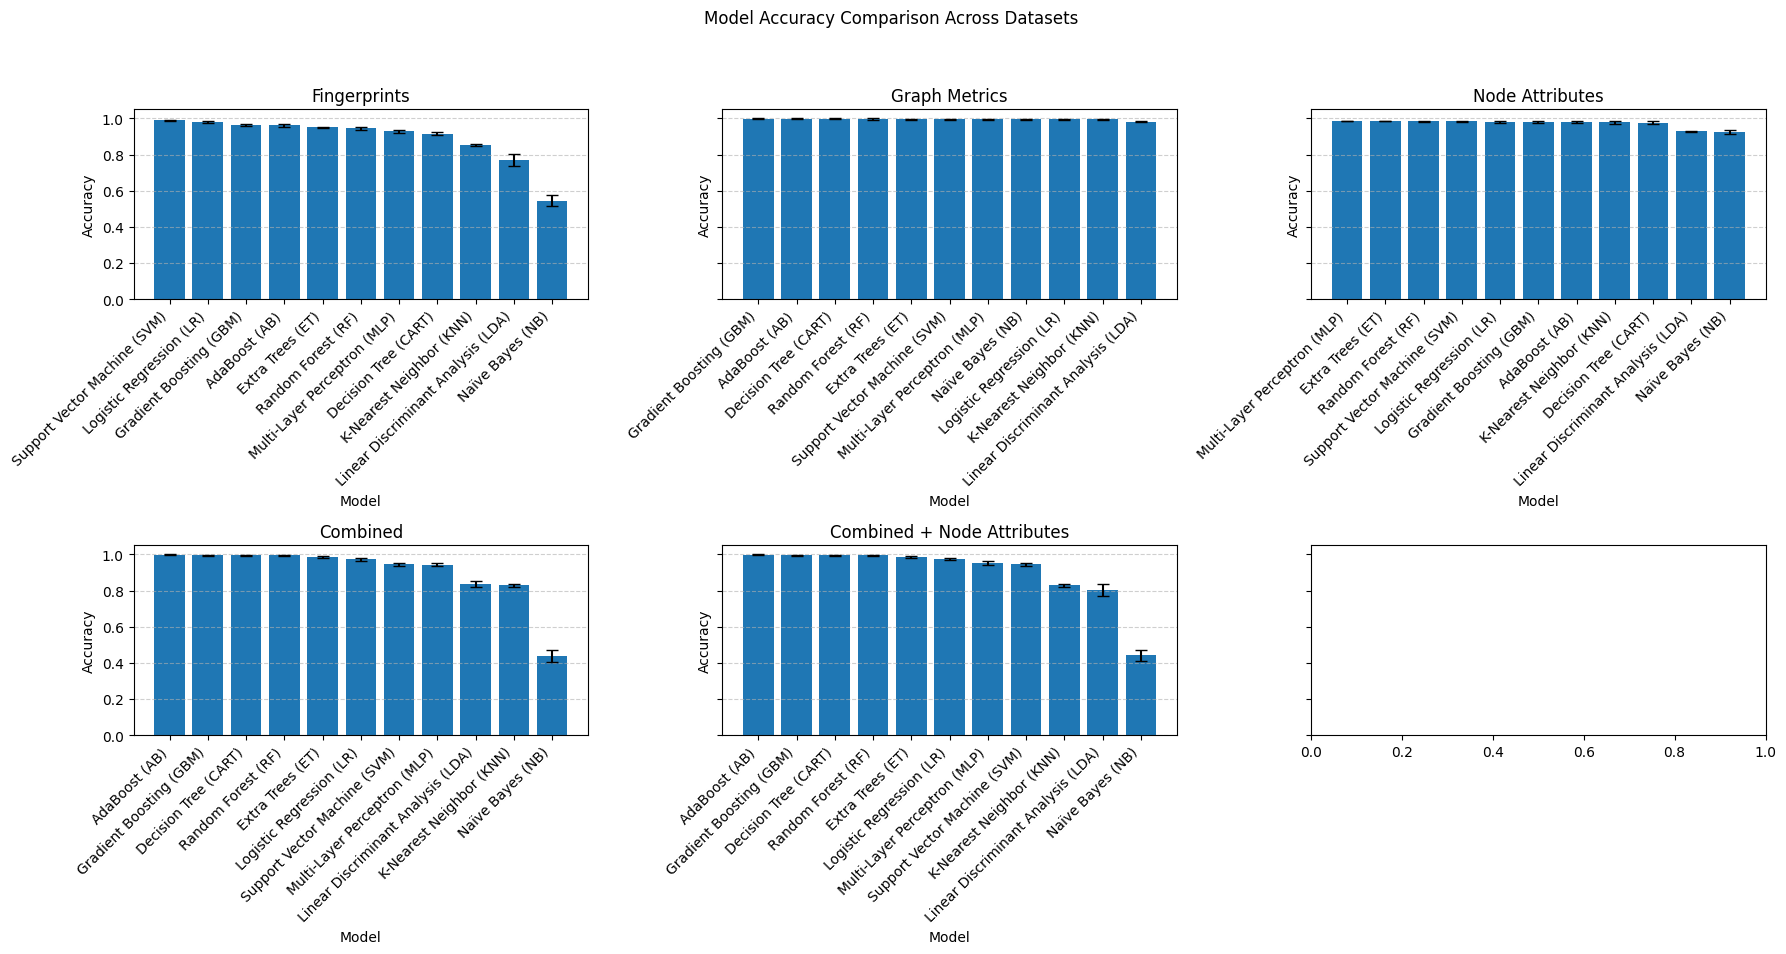

In [32]:
import matplotlib.pyplot as plt

# Plot settings
fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
axs = axs.flatten()  # Flatten to 1D array for easy iteration

for ax, (dataset_name, df) in zip(axs, all_results.items()):
    df_sorted = df.sort_values('accuracy_mean', ascending=False)
    ax.bar(df_sorted['model'], df_sorted['accuracy_mean'], yerr=df_sorted['accuracy_std'], capsize=4)
    ax.set_title(f"{dataset_name}")
    ax.set_xlabel("Model")
    ax.set_ylabel("Accuracy")
    ax.set_xticklabels(df_sorted['model'], rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle("Model Accuracy Comparison Across Datasets")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()